In [1]:
from IPython.display import display

from sympy import *
init_printing()

import functools
from monom import *

$n$ -- порядок разложения в ряд Тейлора для аппроксимации схемы

In [2]:
n, n1 = 8, 6
x, y, h, re = symbols('x y h Re', real=True)
u, v, p, f1, f2 = (f(x, y) for f in symbols('u v p f1 f2', cls=Function))

функция T раскладывает выражения $f$ в точке $(x_{i1}, y_{k1})$ в ряд Тейлора

In [3]:
def T(f, i1, k1):
    return sum(sum(\
        diff(f, x, i, y, k)*(h*(i1+0))**i*(h*k1)**k/(factorial(i)*factorial(k))\
            for i in range(n-k)) for k in range(n))

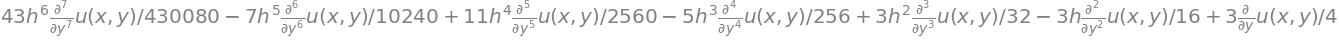

In [4]:
ratsimp((T(u, 0, Rational(1, 2))-T(u, 0, -1))/(2*h))

In [5]:
Monom.variables = 2 + 1
Monom.cmp = Monom.TOPdeglex
Monom.zero = Monom(0 for v in range(Monom.variables))
F = dict(zip((u, v, p, f1, f2),\
             (Monom(0 if v else i for v in range(Monom.variables)) for i in range(1, 6))))
V = dict(zip((x, y),\
             (Monom(0 if v != i else 1 for v in range(Monom.variables)) for i in range(1, 3))))

In [9]:
def d2P(eq):
    r = []
    for f in F.keys():
        k = eq.coeff(f)
        if k:
            r.append((F[f], eq.coeff(f)))
    def d2U(expr):
        if expr.args:
            if expr.func == Derivative:
                m = F[expr.args[0]]
                for x in expr.args[1:]:
                    m = m*V[x[0]]**x[1]
                r.append((m, eq.coeff(expr)))
            else:
                for a in expr.args: d2U(a)
    d2U(eq)
    return sorted(r, key=functools.cmp_to_key(lambda a, b: Monom.cmp(b[0], a[0])))

def clip(f, l):
    f = expand(f)
    return [d2P(f.coeff(h, i)) for i in range(l)]

F2p, V2p = ["u", "v", "p", "f1", "f2"], ["x", "y"]
def p2L(p):
    def m2L(m):
        f = F2p[m[0] - 1]
        r = []
        for v in range(1, Monom.variables):
            for i in range(m[v]):
                r.append(V2p[v-1])
        if not r:
            return Symbol(f, real=True)
        else:
            return Symbol(f + "_{%s}" % "".join(r), real=True)
    return sum(h**i*sum(m2L(m)*c for m, c in p[i]) for i in range(len(p)) if p[i])

def add_mc(self, other, m, c):
    assert c
    p = []
    i, j, iend, jend = 0, 0, len(self), len(other)
    while i < iend and j < jend:
        m1, c1 = other[j][0]*m, other[j][1]*c
        cmp = Monom.cmp(self[i][0], m1)
        if cmp > 0:
            p.append((self[i][0], self[i][1]))
            i += 1
        elif cmp < 0:
            p.append((m1, c1))
            j += 1
        else:
            k = self[i][1] + c1
            if k:
                p.append((self[i][0], k))
            i += 1
            j += 1
    while i < iend:
        p.append((self[i][0], self[i][1]))
        i += 1
    while j < jend:
        p.append((other[j][0]*m, other[j][1]*c))
        j += 1
    return p

def autoReduce(G):
    l = len(G[0])
    assert all(l == len(g) for g in G)
    for j in range(1, l):
        for k in range(len(G)):
            i = 0
            while i < len(G[k][j]):
                m, c = G[k][j][i]
                for g in G:
                    if m.divisible(g[0][0][0]):
                        m1, c1 = m/g[0][0][0], ratsimp(-c/g[0][0][1])
                        for r in range(j, l):
                            G[k][r] = add_mc(G[k][r], g[r-j], m1, c1)
                        break
                else:
                    i += 1
def NF(f, G):
    l = len(f)
    assert all(l == len(g) for g in G)
    for j in range(l):
        i = 0
        while i < len(f[j]):
            m, c = f[j][i]
            for g in G:
                if m.divisible(g[0][0][0]):
                    m1, c1 = m/g[0][0][0], ratsimp(-c/g[0][0][1])
                    for r in range(j, l):
                        f[r] = add_mc(f[r], g[r-j], m1, c1)
                    break
            else:
                i += 1
    return f

def Spoly(f, g):
    assert len(f) == len(g)
    m = f[0][0][0].lcm(g[0][0][0])
    mf, mg = m/f[0][0][0], m/g[0][0][0]
    cf, cg = -g[0][0][1], f[0][0][1]
    r = []
    for i in range(len(f)):
        r.append(add_mc([], f[i], mf, cf))
    for i in range(len(g)):
        r[i] = add_mc(r[i], g[i], mg, cg)
    return r

Входные данные для алгоритма.

Система уравнений
\begin{equation*}
\begin{split}
 &u_x + u_y = 0, \\
 &-\frac{1}{Re}(u_{xx} + u_{yy}) + p_x = f_1, \\
 &-\frac{1}{Re}(v_{xx} + v_{yy}) + p_y = f_2.
\end{split}
\end{equation*}

Разностная схема:
\begin{equation*}
\begin{split}
 &\frac{u_{j+1, k+1/2} - 2 u_{j, k+1/2} + u_{j-1, k+1/2}}{h^2} + \frac{u_{j, k+3/2} - 2 u_{j, k+1/2} + u_{j, k-1/2}}{h^2}
 +\frac{p_{j+1/2, k+1/2} - p_{j-1/2, k+1/2}}{2h} = f_{1_{j, k+1/2}}, \\
&\frac{1}{Re}\frac{v_{j+3/2, k} - 2 u_{j+1/2, k} + v_{j-1/2, k}}{h^2} + 
\frac{1}{Re}\frac{v_{j+1/2, k+1} - 2 u_{j+1/2, k} + v_{j+1/2, k-1}}{h^2}
 +\frac{p_{j+1/2, k+1/2} - p_{j+1/2, k-1/2}}{2h} = f_{2_{j+1/2, k}}, \\ 
 &\frac{1}{Re}\frac{u_{j+1/2, k} - u_{j-1/2, k}}{h} + \frac{1}{Re}\frac{v_{j, k+1/2} - v_{j, k-1/2}}{h} = 0
\end{split}
\end{equation*}


## 1 шаг. Строим базис Грёбнера для упорядочения TOP $u \succ v \succ p$ и degrevlex $x \succ y$
\begin{equation*}
\begin{split}
 &u_x + v_y = 0, \\
 &\frac{1}{Re}v_{xy} - \frac{1}{Re}u_{yy} + p_x - f_1, \\
 &-\frac{1}{Re}v_{xx} - \frac{1}{Re}v_{yy} + p_y - f_2, \\
 &p_{xx} + p_{yy} - {f_1}_y - {f_2}_y. \\
\end{split}
\end{equation*}

## 2 шаг. Зная базис Грёбнера 
\begin{equation*}
\begin{split}
 eq_1 &=u_x + u_y, \\
 eq_2 &=-\frac{1}{Re}(u_{xx} + u_{yy}) + p_x - f_1, \\
 eq_3 &=-\frac{1}{Re}(v_{xx} + v_{yy}) + p_y - f_2, \\ 
 eq_4 &= p_{xx} + p_{yy} - {f_1}_y - {f_2}_y. \\
\end{split}
\end{equation*}
## получаем условие интегрируемости для первоначальной системы
\begin{equation*}
{eq_2}_x + {eq_3}_y + \frac{1}{Re}{eq_1}_{xx} + \frac{1}{Re}{eq_1}_{yy} - eq4 = 0
\end{equation*}

In [7]:
# вспомогательные функции
def Dx(f): return (T(f, Rational(1, 2), 0) - T(f, -Rational(1, 2), 0))/h
def Dy(f): return (T(f, 0, Rational(1, 2)) - T(f, 0, -Rational(1, 2)))/h
def Dxx(f): return (T(f, 1, 0) - 2*T(f, 0, 0) + T(f, -1, 0))/h**2
def Dyy(f): return (T(f, 0, 1) - 2*T(f, 0, 0) + T(f, 0, -1))/h**2

## 3 шаг. Строим разложения разностных уравнения до заданного порядка.
В данном случае до $O(h^4)$

In [10]:
eq1 = ratsimp(Dx(u)+Dy(v))
eq1 = clip(eq1, n1)
p2L(eq1)

In [11]:
eq2 = ratsimp(-(Dxx(u) + Dyy(u)) + Dx(p) - f1)
eq2 = clip(eq2, n1)
p2L(eq2)

In [12]:
eq3 = ratsimp(-(Dxx(v) + Dyy(v)) + Dy(p) - f2)
eq3 = clip(eq3, n1)
p2L(eq3)

In [13]:
eq2a = Spoly(eq2, eq1)
p2L(eq2a)

In [14]:
eq4 = Spoly(eq2a, eq3)
eq4a = Spoly(eq4, eq1)
p2L(eq4a)

## 5 шаг. Выполняем autoReduce для полученной системы

In [15]:
G = [eq1, eq2a, eq3, eq4a]
autoReduce(G)
for g in G:
    display(p2L(g))

## 5 шаг. Проверяем условие интегрируемости с шага 2. 
## Порядок по $h$ должен быть выше чем порядок аппроксимации
## разностных схем. В данном случае $O(h^4)$

In [16]:
p2L(Spoly(eq2a, eq3))

In [17]:
p2L(NF(Spoly(eq2a, eq3), [eq1, eq2a, eq3, eq4a]))